In [161]:
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
dfi = pd.read_csv("predict_intentions.csv").drop_duplicates()
dfi

,execution_id,nullify,cardinality
0,I-120-12-0,5.0,1164
1,I-120-12-1,5.0,2604
2,I-120-12-2,5.0,4044
6,I-120-12-3,5.0,5484
7,I-120-12-4,5.0,6924
...,...,...,...
145,Cimice-119-0,0.0,137
146,Cimice-119-1,0.0,274
147,Cimice-119-2,0.0,411
148,Cimice-200-0,0.0,137


In [162]:
duplicated_values = dfi[dfi['execution_id'].duplicated(keep=False)]['execution_id'].unique()
print("Duplicated values:", duplicated_values)
dfi[dfi['execution_id'].isin(duplicated_values)]

Duplicated values: []


,execution_id,nullify,cardinality


In [163]:
dfm = pd.read_csv("predict_models.csv")
dfm

,execution_id,model,time
0,Cimice-200-1,pivot,4
1,Cimice-200-1,univariateTS,34239
2,Cimice-200-1,timeDecisionTree,599
3,Cimice-200-1,timeRandomForest,934
4,Cimice-200-1,decisionTree,282
...,...,...,...
962,I-120-12-0,pivot,3
963,I-120-12-0,timeDecisionTree,26333
964,I-120-12-0,timeRandomForest,28975
965,I-120-12-0,decisionTree,231


In [164]:
dfc = pd.read_csv("predict_components.csv")
dfc["success_time"] = dfc.apply(lambda x: x["success_time"] if x["success_time"] > 0 else x["component_time"], axis=1)
dfc["component_time"] = dfc.apply(lambda x: ((x["success_time"] / x["success"]) * 21) if x["success"] > 0 else float('inf'), axis=1).astype(float)
dfc[dfc["model"] == "multivariateTS"] 

,model,component,interest,sparsity,endog,exog,component_time,success,success_time,execution_id
13,multivariateTS,ALL,0.951560,0.362963,3,6,99333.500,12,56762,Cimice-119-2
24,multivariateTS,ALL,0.986072,0.355556,2,4,32049.500,12,18314,Cimice-119-1
79,multivariateTS,ALL,0.802927,0.043478,3,6,18123.000,6,5178,Cimice-115-2
90,multivariateTS,ALL,0.864925,0.043478,2,4,11665.500,8,4444,Cimice-115-1
175,multivariateTS,ALL,-1.369326,0.041096,6,0,194544.000,8,74112,I-122-6-4
...,...,...,...,...,...,...,...,...,...,...
2937,multivariateTS,ALL,-0.299512,0.040816,3,0,57368.500,12,32782,I-121-3-1
2948,multivariateTS,ALL,-5.260986,0.040816,2,0,18702.250,12,10687,I-121-2-0
3046,multivariateTS,ALL,-3.159265,0.040816,4,0,94066.875,8,35835,I-121-4-2
3060,multivariateTS,ALL,-0.299512,0.040816,3,0,61372.500,12,35070,I-121-3-1


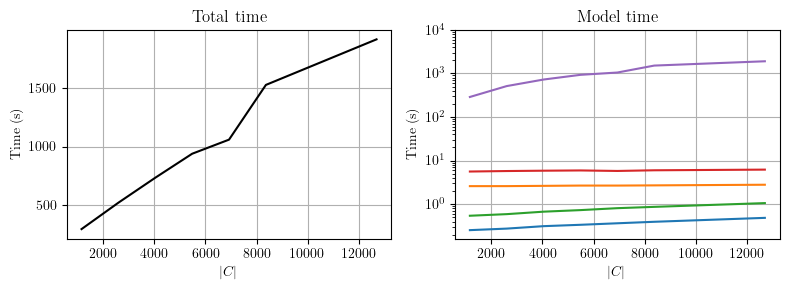

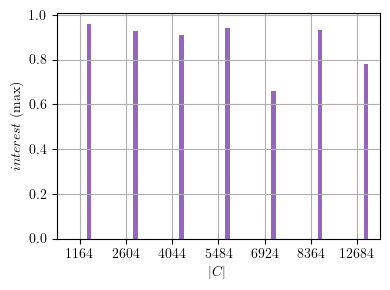

In [165]:
import shutil
import matplotlib
from matplotlib.ticker import MaxNLocator

# shutil.rmtree(matplotlib.get_cachedir())

def plot(s):
    filtered = dfc[dfc['execution_id'].str.contains(s)] #  & dfc['model'].isin(values_to_check) 
    values_to_check = filtered["model"].unique()        # ["timeDecisionTree", "timeRandomForest", "univariateTS", "decisionTree", "randomForest", "multivariateTS"] 
    filtered = filtered.merge(dfi, on=["execution_id"])
    filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-122-")) & (filtered['model'] == "multivariateTS") & (filtered['cardinality'] > 400)].index)
    filtered = filtered.drop(filtered[(filtered['execution_id'].str.contains("-120-")) & (filtered['cardinality'] > 14000)].index)
    filtered["cardinality"] = filtered["cardinality"].astype(int)
    filtered["Predicted values"] = (filtered["cardinality"] * 0.05).astype(int)
    filtered["component_time"] = filtered["component_time"].astype(int) / 1000
    filtered = filtered.rename({"cardinality": "$|C|$", "component_time": "Time (s)", "interest": "Interest", "model": "Model"}, axis=1)
    
    x = "$|C|$"
    if '-116-' in s or '-117-' in s:
        filtered["$|In|$"] = filtered['execution_id'].apply(lambda s: int(s.split('-')[-1]) + 1).astype(int)
        x = "$|In|$"
      
    # fig, ax = plt.subplots(len(values_to_check), 4, figsize=(4 * 4, 3 * len(values_to_check)))
    # ax = ax.flatten()
    df = filtered
    # i = 0
    # for v in values_to_check:
    #     odf = df[df["Model"] == v]
    #     for c in odf["component"].unique():
    #         idf = odf[odf["component"] == c]
    #         idf = idf[[x, "Interest", "Time (s)"]].groupby(x).mean().reset_index()
    #         idf.plot(ax=ax[i],     x=x, y="Interest", label=c)
    #         idf.plot(ax=ax[i + 1], x=x, y="Time (s)", label=c)
    #     adf = odf[["component", x, "Interest"]].groupby(["component", x]).median().reset_index()
    #     adf.boxplot(ax=ax[i + 2], by=x, column="Interest")
    #     ax[i + 0].set_ylim([None, 1])
    #     ax[i + 2].set_ylim([0, 1])
    #     adf = odf[["component", x, "Time (s)"]].groupby(["component", x]).mean().reset_index().groupby([x]).sum().reset_index()
    #     adf.plot(ax=ax[i + 3], x=x, y="Time (s)")
    #     ax[i + 1].set_ylim(0)
    #     ax[i + 3].set_ylim(0)
    #     for j in range(0, 4): 
    #         ax[i + j].grid() 
    #         ax[i + j].legend().set_visible(False)
    #         ax[i + j].set_title(v)
    #     i += 4
    # fig.tight_layout()
    def color_mapper(m):
        if m in ["decisionTree", "dT"]:
            return 'tab:blue'
        elif m in ["timeDecisionTree", "timeDT"]:
            return 'tab:orange'
        elif m in ["randomForest", "rF"]:
            return 'tab:green'
        elif m in ["timeRandomForest", "timeRF"]:
            return 'tab:red'
        elif m == "univariateTS":
            return 'tab:purple'
        elif m == "multivariateTS":
            return 'tab:brown'
        else:
            print(m)
    
    fig, axs = plt.subplots(1, 2, figsize=(8 * 1, 3 * 1)) #, sharey=True 
    axs = axs.flatten()
    i = 0
    ax = axs[i + 1] 
    dff = df.groupby(["execution_id", "Model", "component", "$|C|$"] + (["$|In|$"] if '-116-' in s or '-117-' in s else [])).median().reset_index().groupby(["Model", x]).agg({"Time (s)": "sum", "Interest": "max"})
    dff = dff.reset_index()
    models = sorted(dff["Model"].unique())
    # if "multivariateTS" in models:
    #     models = [x for x in models if x != "multivariateTS"] 
    #     models = models + ["multivariateTS"] 
    if "$|In|$" in dff.columns:
        dff["$|In|$"] = dff["$|In|$"].astype(int) 
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for model in models:
        dff[dff["Model"] == model].plot(x=x, y="Time (s)", kind="line", ax=ax, label=model, c=color_mapper(model), legend=False) 
    ax.set_yscale('log')

    c, p = 1, 0
    while dff["Time (s)"].max() > c:
        c *= 10
        p += 1
    ax.set_yticks([10 ** x for x in range(0, p+1)])
    ax.set_title("Model time")
    ax.set_ylabel('Time (s)')
    ax.grid()
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
    
    # import numpy as np
    # x_ticks = np.arange(len(dff.groupby(x).groups.keys()))  # the label locations
    # width = 0.25  # the width of the bars
    # multiplier = 0
    fig2, ax2 = plt.subplots(1, 1, figsize=(4, 3))
    # for attribute, measurement in dff.groupby(["Model"] ).agg({"Interest": "max"}).items():
    #     offset = width * multiplier
    #     rects = ax2.bar(x_ticks + offset, measurement, width, label=attribute)
    #     ax2.bar_label(rects, padding=3)
    #     multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax2.set_xticks(x_ticks + width, dff.groupby(x).groups.keys())
    # Define a function to set colors based on values
    # .replace({"decisionTree": "dT", "timeDecisionTree": "timeDT", "timeRandomForest": "timeRF", "randomForest": "rF"}) \
    pdf = dff \
        .pivot(index=x, columns="Model", values="Interest") \
        .clip(lower=0)
    # colors = pdf.index.map(color_mapper)
    colors = [color_mapper(col) for col in pdf.columns]
    pdf.plot(kind='bar', ax=ax2, legend=False, color=colors, rot=0)
    legend = ax2.legend(bbox_to_anchor=(0.0, 1.2), ncol=3, loc=2, borderaxespad=0., fontsize=10)
    ax2.set_ylabel("$interest$ (max)")
    # def export_legend(legend, filename="legend.pdf", expand=[-5,-5,5,5]):
    #     import numpy as np
    #     ifig = legend.figure
    #     ifig.canvas.draw()
    #     bbox  = legend.get_window_extent().transformed(ifig.dpi_scale_trans.inverted())
    #     # bbox  = legend.get_window_extent()
    #     # bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    #     # bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    #     ifig.savefig(filename, dpi="figure", bbox_inches=bbox)
    # export_legend(legend)
    legend.remove()
    #  x2.xaxis.set_tick_params(rotation=90)
    ax2.grid()
    fig2.tight_layout()

    dff.pivot(index="Model", columns=x, values="Time (s)").to_latex(s + "model-time.tex", float_format="{:.2f}".format)
    print("")
    dff.pivot(index="Model", columns=x, values="Interest").to_latex(s + "model-int.tex", float_format="{:.2f}".format)

    ax = axs[i]
    dff = dff.groupby([x]).agg({"Time (s)": "sum", "Interest": "max"})
    dff = dff.reset_index()
    if "$|In|$" in dff.columns:
        dff["$|In|$"] = dff["$|In|$"].astype(int) 
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    dff["Intention"] = range(0, len(dff))
    dff["Intention"] = "I" + dff["Intention"].astype(str)
    dff.index = dff["Intention"]
    dff = dff.drop("Intention", axis=1)
    if "-122-" not in s:
        dff.plot(x=x, y="Time (s)", kind="line", ax=ax, legend=False, c="black")
    else: 
        dff[dff["$|C|$"] < 400].plot(x=x, y="Time (s)", kind="line", ax=ax, legend=False, c="black")
        dff[dff["$|C|$"] > 400].plot(x=x, y="Time (s)", kind="line", ax=ax, legend=False, c="black")
    # ax.set_yscale('log')
    # ax.legend(loc=2)
    # ax.set_yticks([1, 10, 100, 1000, 10000])
    ax.set_title("Total time")
    ax.set_ylabel('Time (s)')
    ax.grid()
    fig.tight_layout()

    fig.savefig(f"{s}.svg")
    fig.savefig(f"{s}.pdf")
    dff.transpose().to_latex(s + "overall.tex", float_format="{:.2f}".format)
    

plot('-120-')

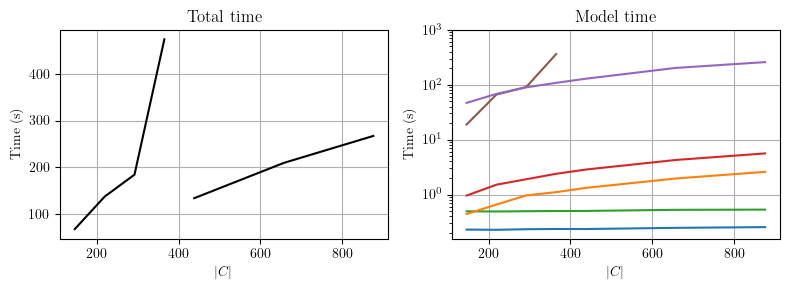

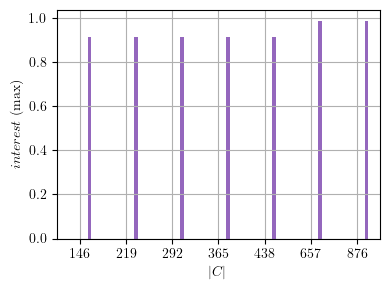

In [166]:
plot('-122-')

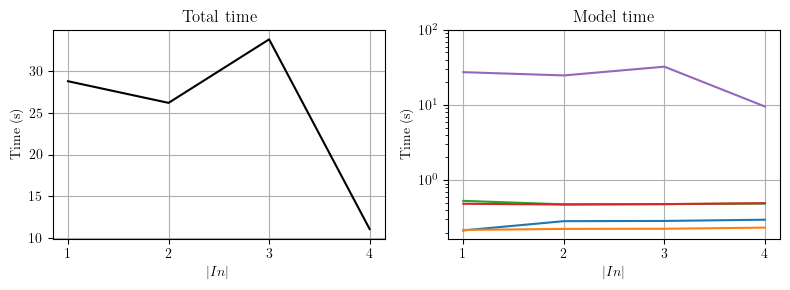

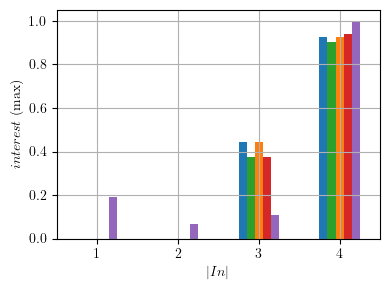

In [167]:
plot('-117-')

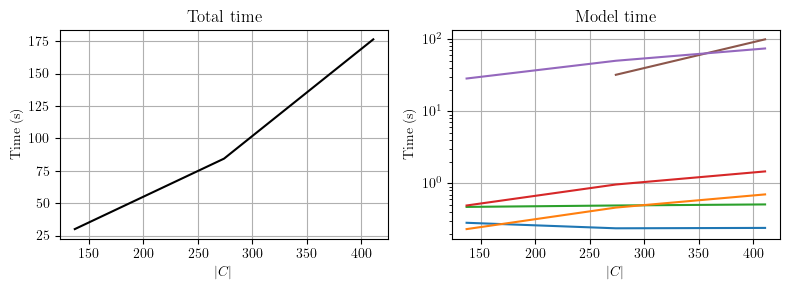

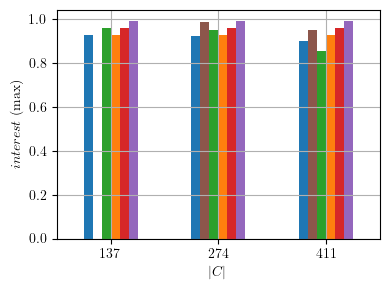

In [168]:
plot('-119-')